In [5]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report

In [6]:
def show_result(test1):
    # Mostrar los resultados
    fig, ax = plt.subplots(2,1,figsize=(6,3))
    ax[0].plot(test1.history['loss'], color='b', label="Training loss")
    ax[0].plot(test1.history['val_loss'], color='r', label="validation loss")
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].grid()

    ax[1].plot(test1.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(test1.history['val_accuracy'], color='r',label="Validation accuracy")
    ax[1].set_ylim(0,1)
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].grid()

    plt.tight_layout()
    plt.show()

In [7]:
# Cargar los datasets
escalado=0
if escalado==0:
    feat_train = np.load('../datasets/feat_train_sinEsc.npy')
    label_train = np.load('../datasets/label_train_sinEsc.npy')
    feat_val = np.load('../datasets/feat_val_sinEsc.npy')
    label_val = np.load('../datasets/label_val_sinEsc.npy')

if escalado==1:
    feat_train = np.load('../datasets/feat_train.npy')
    label_train = np.load('../datasets/label_train.npy')
    feat_val = np.load('../datasets/feat_val.npy')
    label_val = np.load('../datasets/label_val.npy')
    print("SE CARGA EL DATASET ESCALADO")

In [8]:
def scale_dataset(mel_list):
    scaler = StandardScaler()

    scaled_mel_list=[]
    for mel in mel_list:
        # primero aplanar para el scaler
        flattened_mel = mel.reshape(-1,1)
        # pasamos por el scaler
        mel_scaled= scaler.fit_transform(flattened_mel)
        # devolvemos la forma original
        flattened_mel=mel_scaled.reshape(mel.shape)
        # Aumentamos la forma para que encaje en como entrada en la red neuronal
        mel_scaled = np.expand_dims(flattened_mel, axis=-1)
        # Almacenamos en la lista
        scaled_mel_list.append(mel_scaled)

    # pasamos a array para la red neuronal
    scaled_mel_array = np.array(scaled_mel_list) 

    return scaled_mel_array

In [9]:
## Estructura 
inputs = layers.Input(shape=(128, 141, 1))

### VGG-16

# Bloque 1
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 4
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Bloque 5
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Capas densas
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(4, activation='softmax')(x)  # Adaptar para el número de clases en tu problema

VGG16 = models.Model(inputs, outputs, name='VGG16')

# Resumen del modelo
VGG16.summary()


Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 141, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 141, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 141, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 70, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 70, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 70, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 35, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 35, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 35, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 17, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 17, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 17, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,38

 Total params: 65,069,764 (248.22 MB)

 Trainable params: 65,069,764 (248.22 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define el optimizador y compila el modelo
optimizer = optimizers.Adam(learning_rate=0.0001)
VGG16.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
# Entrena el modelo
history = VGG16.fit(feat_train, label_train,
                   batch_size=32, epochs=50,
                   validation_data=(feat_val, label_val),
                   verbose=1,
                   callbacks=[early_stopping]
                   )

test_loss, test_acc = VGG16.evaluate(feat_val, label_val, verbose=2)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.2782 - loss: 1.3913 - val_accuracy: 0.3188 - val_loss: 1.3751
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.2991 - loss: 1.3403 - val_accuracy: 0.4493 - val_loss: 1.2669
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.4387 - loss: 1.1562 - val_accuracy: 0.6667 - val_loss: 0.9059
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6255 - loss: 0.9275 - val_accuracy: 0.7391 - val_loss: 0.5493
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7839 - loss: 0.5874 - val_accuracy: 0.7246 - val_loss: 0.5685
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.8357 - loss: 0.5222 - val_accuracy: 0.8551 - val_loss: 0.3971
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8818 - loss: 0.3905 - val_accuracy: 0.8116 - val_loss: 0.4464
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9066 - loss: 0.2931 - val_accuracy: 0.8261 - val_loss:

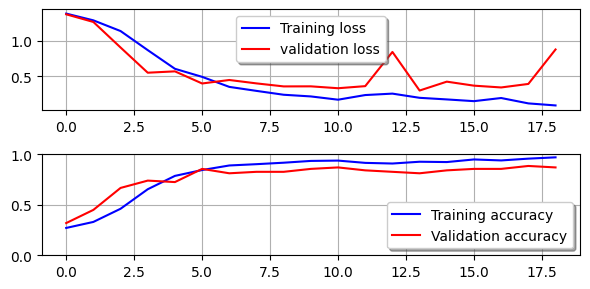

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
              precision    recall  f1-score   support

     Paisaje       0.83      0.77      0.80        13
       Avion       0.95      1.00      0.97        19
       Motor       0.71      0.71      0.71        17
       Voces       0.75      0.75      0.75        20

    accuracy                           0.81        69
   macro avg       0.81      0.81      0.81        69
weighted avg       0.81      0.81      0.81        69



In [13]:
show_result(history)
# Haz predicciones en el conjunto de validación
y_pred = VGG16.predict(feat_val)

# Convierte las predicciones a etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(label_val, axis=1)

# Calcula precision, recall, y F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=['Paisaje', 'Avion', 'Motor', 'Voces'])
print(report)

In [14]:
VGG16.save("VGG16_b.keras")

-----------

Test de validacion

In [15]:
import pandas as pd
import librosa


In [16]:
# test_dataset=pd.read_pickle("../SMA07415_20221115_073002.pkl") # 2 aviones
test_dataset=pd.read_pickle("../SMA07415_20221113_073002.pkl") # 4 aviones, presenta algún fallo
test_dataset=pd.read_pickle("../SMA07415_20220608_082002.pkl") # 2-3 aviones y mucho pájaro de fondo
test_dataset=pd.read_pickle("../v2_dataset.pkl") # no detecta motor de barca
sr=24000

In [17]:
def extract_mel_spectrogram(audio, sr, n_mels=128,fmax=None):
  # Permite extraer el espectrograma mel de un dataset completo y guardarlo en una lista.
    mel_spectrogram=librosa.feature.melspectrogram(y=audio, sr=sr,
                                                   n_fft=2*1024, hop_length=512,
                                                   n_mels=n_mels,
                                                   fmax=fmax)
    mel_spectrogram_db=librosa.power_to_db(mel_spectrogram,ref=np.max)
    return mel_spectrogram_db

In [18]:
mel_list = []
for _, row in test_dataset.iterrows():
    audio_fragment=row["Signal"]
    mel_S=extract_mel_spectrogram(audio_fragment,sr)
    mel_list.append(mel_S)

if escalado==1:
    input_mel_array=scale_dataset(mel_list)
    print("SE APLICA ESCALADO AL DATASET DE PRUEBAS")
if escalado==0:
    input_mel=np.expand_dims(mel_list, axis=-1)
    input_mel_array=np.array(input_mel)

print(input_mel_array.shape)

(110, 128, 141, 1)


In [19]:
predictions_test = VGG16.predict(input_mel_array)
predicted_labels_test = np.argmax(predictions_test,axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step


C:\Users\david\AppData\Local\Temp\ipykernel_15392\3123537776.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


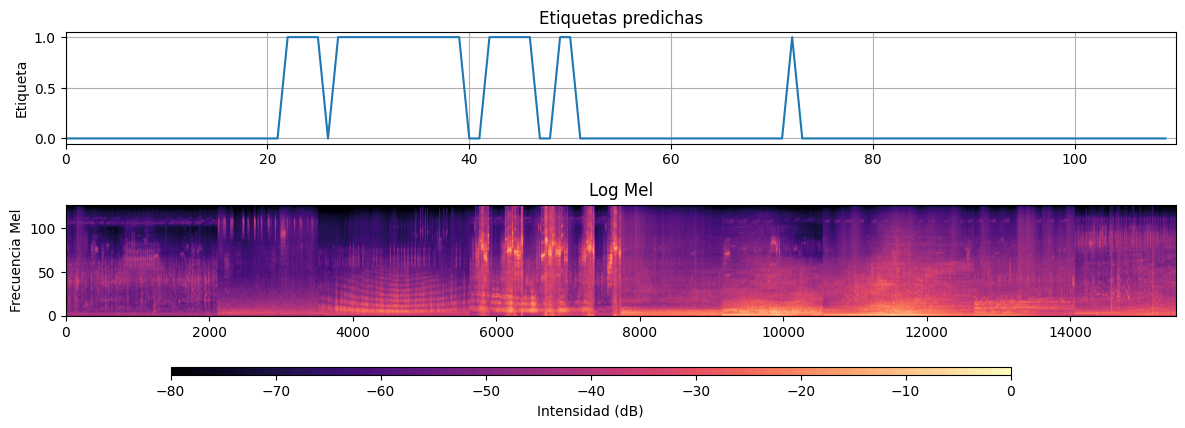

In [20]:
test_signal=np.concatenate(test_dataset["Signal"])
hop_length=512
n_fft=2*1024
n_mels=128
fmax=None
S_Mel = librosa.feature.melspectrogram(y=test_signal, sr=sr, n_fft=n_fft,hop_length=hop_length, n_mels=n_mels,fmax=fmax)
S_Log_Mel_dB = librosa.power_to_db(S_Mel,ref=np.max)

fig, axis = plt.subplots(2,1,figsize=(12,4))
axis[0].plot(predicted_labels_test)
axis[0].set_title("Etiquetas predichas")
axis[0].set_ylabel("Etiqueta")
axis[0].set_xlim([0,len(predicted_labels_test)])
axis[0].grid()

# img2=librosa.display.specshow(S_Log_Mel_dB, sr=sr, x_axis="time", y_axis="linear",cmap="jet",ax=axis[1])
img2=plt.imshow(S_Log_Mel_dB, aspect='auto', origin='lower', cmap='magma')
axis[1].set_title("Log Mel")
axis[1].set_ylabel("Frecuencia Mel")

# Crear un nuevo axis para la colorbar horizontal
cbar_axis = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(img2, cax=cbar_axis, orientation="horizontal")
cbar.set_label("Intensidad (dB)")

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

In [21]:
from IPython.display import Audio
Audio(data=test_dataset["Signal"][80],rate=sr)